# Just plot it

## 0. Necessary imports + initial stuff

In [1]:
import configparser
import argparse
import sys
import numpy as np
from backgrounds import utils
from matplotlib import pyplot as plt
from chainconsumer import ChainConsumer
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
def update_mpl(mpl):
    rcparams = {}
    rcparams['axes.linewidth'] = 0.5
    rcparams['font.family'] = 'serif'
    rcparams['font.size'] = 18
    rcparams['legend.fontsize'] = 14
    rcparams['mathtext.fontset'] = "stix"
    mpl.rcParams.update(rcparams) # update plot parameters
    useserif=True
    plottempsetc=False
    mpl.rcParams['text.usetex']=True
    return mpl
mpl = update_mpl(mpl)

from eryn.state import State
from eryn.ensemble import EnsembleSampler
from eryn.prior import uniform_dist
from eryn.moves import GaussianMove
from eryn.backends import HDFBackend

# Load the chains
chains_dir = '/Users/ngalanis/LISA_Data/chains/' # /home/karnesis/work/data/sgwb/backgrounds/
backendname = "rand1_fs2e-01_omega4.5e-12_n0.0e+00"
backend = HDFBackend(chains_dir + backendname + '/' + backendname + '.h5')

# Set the paths (tensor)
# gw_tdi_file = '/mnt/wd_hdd_6TB/nikos/DATA/backgrounds/signal/run-1/tdi-0.h5'
# noise_tdi_file = '/mnt/wd_hdd_6TB/nikos/DATA/backgrounds/noise/2022-10-18_16h29_noise_tdi2_5s.h5'
# orbit_file = '/mnt/wd_hdd_6TB/nikos/DATA/backgrounds/old_run_noise_only_paper/keplerian-orbits.h5'
# config_path = "/home/karnesis/work/Git/backgrounds/configs/config_data_both_2e-1Hz_dynamic.ini"
# conf = '/home/karnesis/work/Git/backgrounds/configs/config_simu_exp_2e-1Hz.ini'
# code_dir = '/home/karnesis/work/Git/backgrounds/tests/'

# Set the paths (my machine)
gw_tdi_file = '/Users/ngalanis/LISA_Data/signal/run-1/tdi-0.h5'
noise_tdi_file = '/Users/ngalanis/LISA_Data/noise/2022-10-18_16h29_noise_tdi2_5s.h5'
orbit_file = '/Users/ngalanis/LISA_Data/keplerian-orbits.h5'
config_path = "/Users/ngalanis/backgrounds/configs/config_data_both_2e-1Hz_dynamic.ini"
conf = '/Users/ngalanis/backgrounds/configs/config_simu_exp_2e-1Hz.ini'
code_dir = '/Users/ngalanis/backgrounds/tests/'

# Output dir
output_dir = backendname + "/"

# Read the configuration file
jobconfig = configparser.ConfigParser()
jobconfig.read(config_path)

sys.path.append(code_dir)
from full_analysis_data_fullcov_dynamic import preprocess_func

# Configure program arguments.
parser = argparse.ArgumentParser(
    description="A wrapper script to run Dynamical Parameter Estimation on simulated data"
)

parser.add_argument(
    "-w",
    "--omega",
    type=float,
    default=None,
    help="SGWB energy density associated with the data",
)

parser.add_argument(
    "-n",
    "--nindex",
    type=float,
    default=None,
    help="SGWB power law index associated to the data",
)

parser.add_argument(
    "-p",
    "--prefix",
    type=str,
    default=None,
    help="Prefix to append to output folder name",
)

parser.add_argument(
    "-o",
    "--output",
    type=str,
    default=None,
    help="Output directory to store results",
)

parser.add_argument(
    "-s",
    "--scale",
    type=float,
    default=5,
    help="Re-scaling of the SGWB signal",
)

parser.add_argument(
    "-no",
    "--noise",
    type=str,
    default=None,
    help="TDI noise path",
)

parser.add_argument(
    "-si",
    "--signal",
    type=str,
    default=None,
    help="TDI signal path",
)

parser.add_argument(
    "-c",
    "--conf",
    type=str,
    default=conf,
    help="Simulation configuration path",
)   

parser.add_argument(
    "-i",
    "--initial",
    type=str,
    default=None,
    help="Path to parameter files to initialize the search",
)

parser.add_argument(
    "-r",
    "--rseed",
    type=int,
    default=12345,
    help="The random seed",
)

parser.add_argument(
    '-t',  
    '--testplot', 
    action='store_true', 
    help='Flag to make a test plot.')

parser.add_argument(
        '-an',  
        '--analytic_noise', 
        action='store_true', 
        help='Flag to fit analytic noise instead of the splines model.'
)

# Parse the input.
args = parser.parse_args("")

# Get the output dir
output_dir = chains_dir + backendname + '/'

# Compute likelihood object 
loglike, sampler_conf = preprocess_func(jobconfig, args, output_dir, outputdata=True)

/opt/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [2]:
print(sampler_conf.keys())

dict_keys(['coords in', 'indices', 'moves', 'betas', 'L0', 'branch names', 'priors', 'ndims', 'nleaves_max', 'nleaves_min', 'data'])


In [3]:
print(sampler_conf['data'].keys())

dict_keys(['xyz data smoothed', 'xyz signal', 'xyz noise', 'gmat', 'transform_xyz', 'signal_cls', 'noise_cls', 'tdi_corr', 'f', 'inds'])


## Get the sampling settings

In [4]:
nsteps = jobconfig["sampler"].getint("Iterations")
burnin = jobconfig["sampler"].getint("Burnin")
ntemps = jobconfig["sampler"].getint("Temperatures")
nwalkers = jobconfig["sampler"].getint("Walkers")
maxKnotNumber_noise  = jobconfig["likelihood"].getint("maxKnotNumber_noise")
maxKnotNumber_signal = jobconfig["likelihood"].getint("maxKnotNumber_signal")
ftol = 0.1

## 5. Estimating the number of knots dynamically [noise]

In [5]:
def get_clean_chain(coords, ndim, temp=0):
    naninds    = np.logical_not(np.isnan(coords[:, temp, :, :, 0].flatten()))
    print(np.sum(naninds))
    samples_in = np.zeros((coords[:, temp, :, :, 0].flatten()[naninds].shape[0], ndim))  # init the chains to plot
    # get the samples to plot
    for d in range(ndim):
        givenparam = coords[:, temp, :, :, d].flatten()
        samples_in[:, d] = givenparam[
            np.logical_not(np.isnan(givenparam))
        ]  # Discard the NaNs, each time they change the shape of the samples_in
    return samples_in

In [6]:
temp = 0 

ndim_knots = 2
ndim_edges = 2

try:
    samples_knots_noise = get_clean_chain(backend.get_chain()['noise_knots'], ndim_knots)
    samples_edges_noise = get_clean_chain(backend.get_chain()['noise_edges'], ndim_edges)
except:
    print('- No spline PSD noise found. Will skip... ')

- No spline PSD noise found. Will skip... 


In [7]:
try:
    mpl = update_mpl(mpl)
    paramnames = [r'$\log f_{j,k}$',r'$\log S_{j,k}$']

    clr = ['#6495ED', '#FFA500']

    c = ChainConsumer()
    c.add_chain(samples_knots_noise, parameters=paramnames, name='Knots in-between [Noise]', color=clr[0]) # 
    c.configure(bar_shade=True, plot_hists=False)
    fig = c.plotter.plot(figsize=(3, 3)); # filename="0.pdf"
    ff = np.linspace(-9,-3, num=1000)
    ax_list = fig.axes
    link_noise = sampler_conf['data']['noise_cls'].other_noise_model(np.exp(ff))
    ax_list[0].plot(ff, 
                    np.log(link_noise), 
                    color='k', lw=1.5,linestyle='-')
    #plt.savefig(output_dir + "post_k_noise.pdf", bbox_inches='tight', dpi=600)
    mpl = update_mpl(mpl)

    c.add_chain(samples_edges_noise, parameters=[r'$S_{h, \mathrm{min}}$', r'$S_{h, \mathrm{max}}$'], name='Edges [Noise]', color=clr[1])
    fig = c.plotter.plot(figsize=(7, 7));
    mpl = update_mpl(mpl)

    fig = c.plotter.plot_walks();
    mpl = update_mpl(mpl)
except:
    print('- No spline PSD noise found. Will skip... ')

- No spline PSD noise found. Will skip... 


## 5. Estimating the analytic noise model [noise]

10000


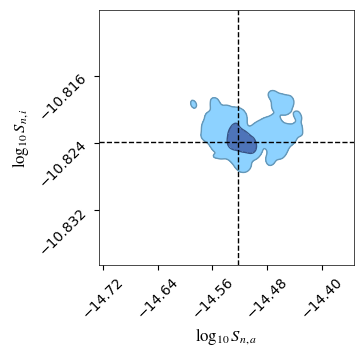

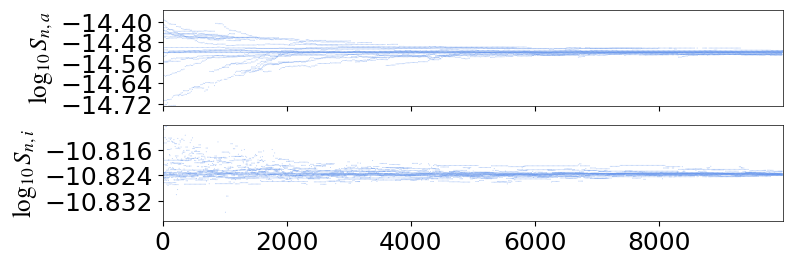

In [8]:
try:
    ndim_link = 2
    samples_analytic_noise = get_clean_chain(backend.get_chain()['link_noise'], ndim_link)
    
    mpl = update_mpl(mpl)
    paramnames = [r'$\log_{10} S_{n,a}$',r'$\log_{10} S_{n,i}$']

    clr = ['#6495ED', '#FFA500']

    c = ChainConsumer()
    c.add_chain(samples_analytic_noise, parameters=paramnames, name='Analytical model [Noise]', color=clr[0]) # 
    c.configure(bar_shade=True, plot_hists=False)
    fig = c.plotter.plot(figsize=(3, 3), truth=[np.log10(3e-15), np.log10(15e-12)]); # filename="0.pdf"
    mpl = update_mpl(mpl)

    fig = c.plotter.plot_walks();
    mpl = update_mpl(mpl)
except:
    print('- No analytic model for the PSD noise found. Will skip... ')

## 5. Estimating the number of knots dynamically [signal]

In [9]:
samples_knots_signal = get_clean_chain(backend.get_chain()['signal_knots'], ndim_knots)
samples_edges_signal = get_clean_chain(backend.get_chain()['signal_edges'], ndim_edges)

39531
10000


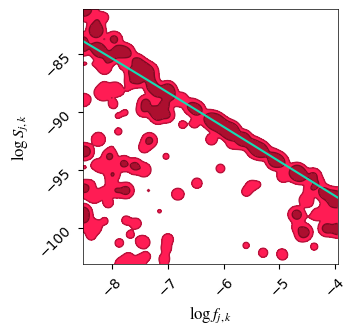

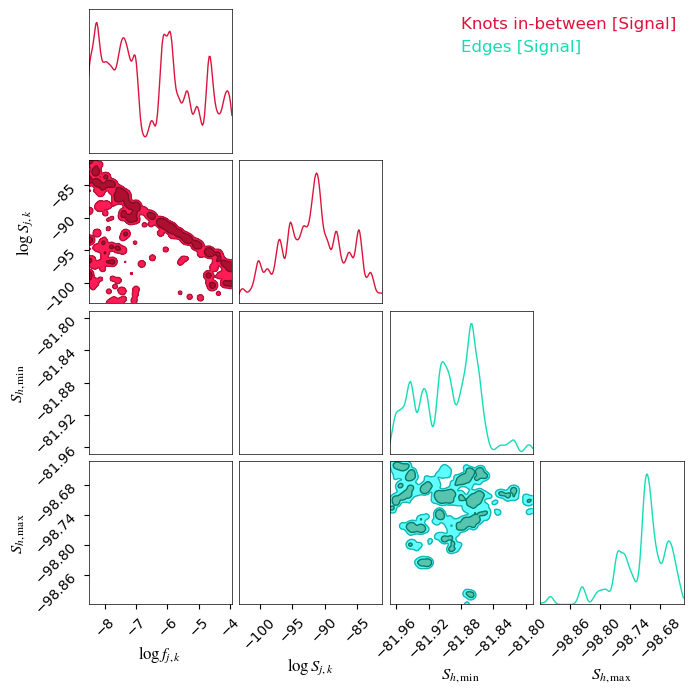

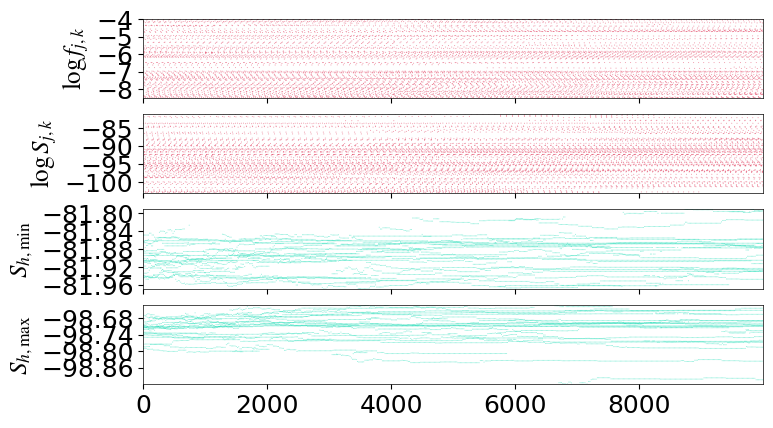

In [10]:
# Plot with marginalized PDFs in order to check
mpl = update_mpl(mpl)

clr = ['#dc143c', '#14dcb4'] #mpl.colors.cnames["royalblue"]
paramnames = [r'$\log f_{j,k}$',r'$\log S_{j,k}$']

c = ChainConsumer()
c.add_chain(samples_knots_signal, parameters=paramnames, name='Knots in-between [Signal]', color=clr[0]) 
c.configure(bar_shade=True, plot_hists=False)
fig = c.plotter.plot(figsize=(3, 3)); # filename="0.pdf"
ff = np.linspace(-9,-3, num=1000)
ax_list = fig.axes
logomega = np.log(1.8e-13 * 5**2 * 1e14)
inj_sig = sampler_conf['data']['signal_cls'].compute_strain_psds([logomega, 0])
    
ax_list[0].plot(np.log(sampler_conf['data']['f'][sampler_conf['data']['inds']]), 
                np.log(inj_sig), 
                color=clr[1], lw=1.5,linestyle='-')
# plt.savefig(output_dir + "post_k_noise.pdf", bbox_inches='tight', dpi=600)
mpl = update_mpl(mpl)

c.add_chain(samples_edges_signal, parameters=['$S_{h, \mathrm{min}}$', '$S_{h, \mathrm{max}}$'], name='Edges [Signal]', color=clr[1])
fig = c.plotter.plot(figsize=(7, 7));
mpl = update_mpl(mpl)

fig = c.plotter.plot_walks();
mpl = update_mpl(mpl)

In [11]:
nbrsmx = maxKnotNumber_noise

def get_clean_k_chains(backend, temp=0):
    inds = backend.get_value("inds")  # Get the leaves out
    branches = {name: np.sum(inds[name], axis=-1, dtype=int) for name in inds}
    k_chain  = dict()
    for (branch) in (branches):  # Get the total number of components/branches per temperature
        if branch == list(branches.keys())[0]:
            k_chain[branch] = branches[branch][:, temp].flatten()
        else:
            k_chain[branch] = branches[branch][:, temp].flatten()
    return k_chain

bns = (np.arange(1, nbrsmx + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch 
knots_k_chain = get_clean_k_chains(backend)

- No spline PSD noise found. Will skip... 


<Figure size 1400x400 with 0 Axes>

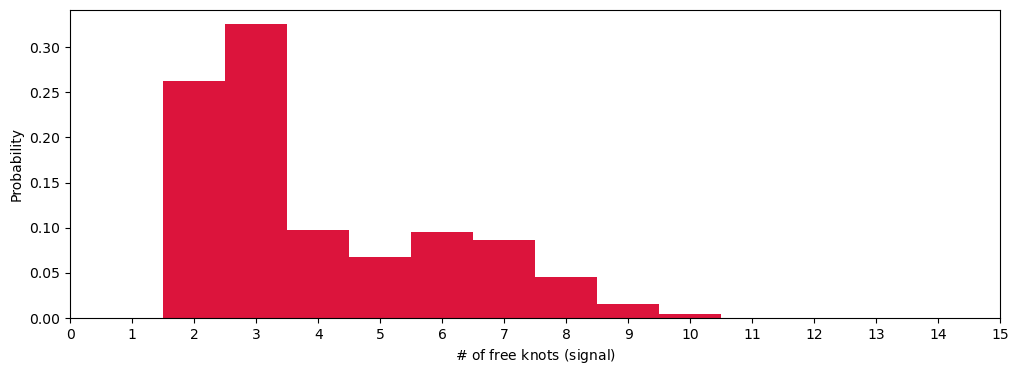

In [12]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

try:
    fig = plt.figure(figsize=(14, 4))
    probs, bins, rects = plt.hist(
            knots_k_chain['noise_knots'],
            bins=bns,
            facecolor='#6495ED',
            histtype='bar',
            color='#6495ED',
            # edgecolor='b',
            # hatch='xx',
            alpha=1,
            lw=2,
            density=True,
            label='knots in-between (noise)'
            )

    # plt.legend(loc='upper left')
    plt.xticks(np.arange(0, nbrsmx+1))
    plt.xlabel(r"$\#$ of free knots (noise)")
    plt.ylabel(r"Probability")
    plt.xlim(0,nbrsmx)
    # plt.savefig("/Users/nikos/Desktop/3.pdf", bbox_inches='tight', dpi=600)
    plt.show()
except:
    print('- No spline PSD noise found. Will skip... ')

fig = plt.figure(figsize=(12, 4))
probs, bins, rects = plt.hist(
        knots_k_chain['signal_knots'],
        bins=bns,
        facecolor='#dc143c',
        histtype='bar',
        color='#dc143c',
        # edgecolor='b',
        # hatch='xx',
        alpha=1,
        lw=2,
        density=True,
        label='knots in-between (signal)'
        )

# plt.legend(loc='upper left')
plt.xticks(np.arange(0, nbrsmx+1))
plt.xlabel(r"$\#$ of free knots (signal)")
plt.ylabel(r"Probability")
plt.xlim(0,15)
# plt.savefig("/Users/nikos/Desktop/3.pdf", bbox_inches='tight', dpi=600)
plt.show()

Plot the result on top of the data

In [13]:
try:
    chains_knots_noise = backend.get_chain()['noise_knots']
    chains_edges_noise = backend.get_chain()['noise_edges']
except:
    chains_link_noise = get_clean_chain(backend.get_chain()['link_noise'], ndim_knots)

chains_knots_signal = backend.get_chain()['signal_knots']
chains_edges_signal = backend.get_chain()['signal_edges']

10000


In [14]:
kk = backend.get_nleaves()

In [15]:
def get_spectrum_for_k(coords, edges, kk, k, logfr, temp=0):
    kk_for_given_temp = kk[:,temp,:]
    where_model_order_k = kk_for_given_temp==k
    try:
        randpoint = np.random.randint(0, high=np.sum(where_model_order_k))
    except:
        randpoint = -1
        return 0, 0

    # get the samples to plot
    pvals = coords[:, temp, :, :]
    pvals = pvals[where_model_order_k]
    pvals = pvals[randpoint]

    pvals = pvals[~np.isnan(pvals).any(axis=1)]
    edg = edges[:, temp, :, :]
    edg = edg[where_model_order_k]
    edg = edg[randpoint][0]

    # Get to compute the PSD
    knots_list = [logfr[0]] + list(pvals[:, 0]) + [logfr[-1]]
    logf_knots = np.array(knots_list)
    
    control_pts = np.array([edg[0]] + list(pvals[:, 1]) + [edg[-1]])
    
    sort_ids = np.argsort(logf_knots)
    logf_knots = logf_knots[sort_ids]
    control_pts = control_pts[sort_ids]
        
    # Change the data and reset the spline class
    interp_model = interpolate.interp1d(logf_knots, control_pts, 
                                        kind='cubic', axis=-1, copy=True, 
                                        bounds_error=False,
                                        fill_value="extrapolate",
                                        assume_sorted=False)
    psd_model = interp_model(logfr)

    return pvals, np.exp(psd_model)

# Just try to see if it works
pp, psdmdl = get_spectrum_for_k(chains_knots_signal, chains_edges_signal, kk['signal_knots'], 6, np.log( sampler_conf['data']['f'][ sampler_conf['data']['inds'] ]), temp=0)

In [16]:
tdi_corr = sampler_conf['data']['tdi_corr']
gmat = sampler_conf['data']['gmat']
vv = np.array([tdi_corr[:, i, i] for i in range(tdi_corr.shape[1])]).T

In [17]:
fff   = np.logspace(-5,-1,num=10)
inds  = sampler_conf['data']['inds']
finds = sampler_conf['data']['f'] [ inds ]

In [18]:
print(sampler_conf['data'].keys(), chains_link_noise.shape)

dict_keys(['xyz data smoothed', 'xyz signal', 'xyz noise', 'gmat', 'transform_xyz', 'signal_cls', 'noise_cls', 'tdi_corr', 'f', 'inds']) (10000, 2)


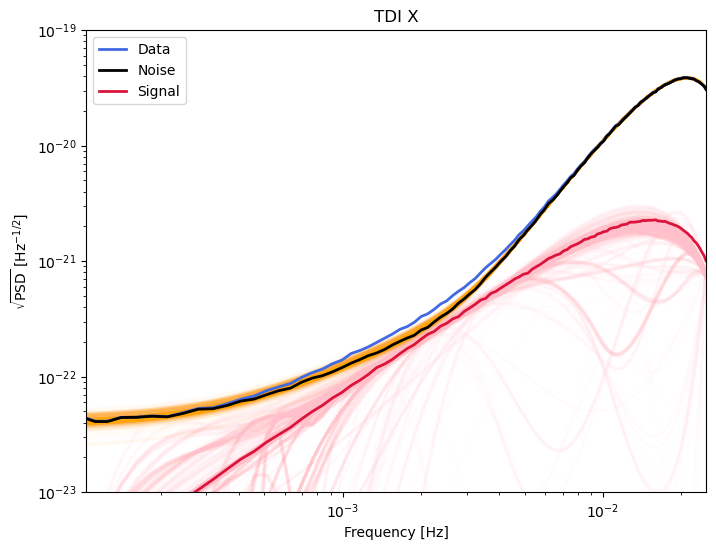

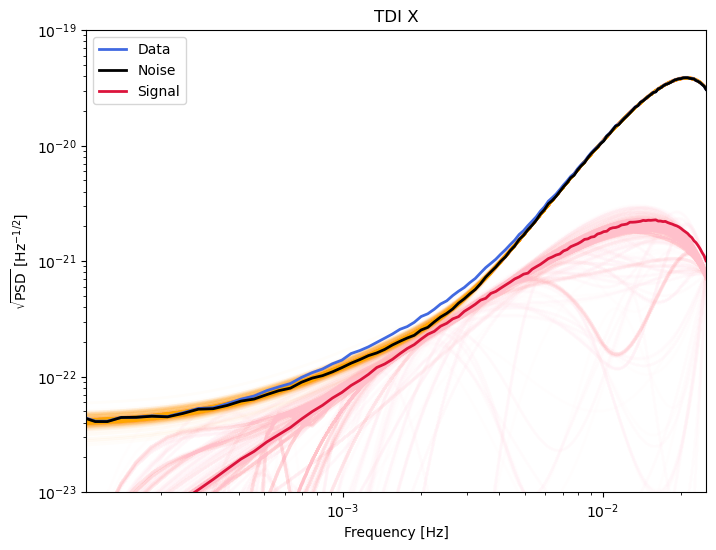

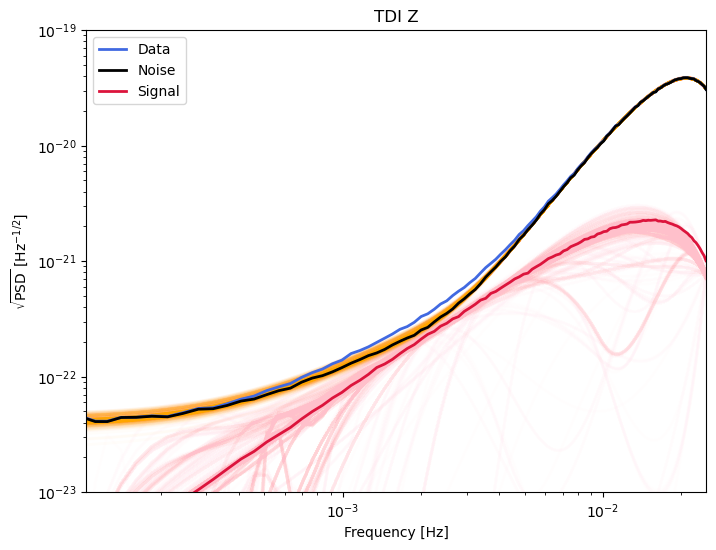

In [20]:
# Plot the TDI PSD estimate
j_channel = 0
xyz_labels = ['X', 'Y', 'Z']
ndraws = 1000
alpha = 0.02

for j_channel in range(3):
    fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    for i in range(ndraws):
        k = np.random.choice((bns+.5).astype(int)[:-1], replace=True, p=probs)

        try:
            _, link_spectrum_noise  = get_spectrum_for_k(chains_knots_noise, chains_edges_noise, kk['noise_knots'], k, np.log(finds), temp=0)
            if isinstance(link_spectrum_noise, int):
                continue
        except:
            link_model_cls = sampler_conf['data']['noise_cls']
            logSa, logSi = chains_link_noise[np.random.randint(0, chains_link_noise.shape[0]), :]
            link_spectrum_noise = link_model_cls.other_noise_model_fit(finds, logatm=logSa, logaoms=logSi).squeeze()
            
        _, spectrum_signal = get_spectrum_for_k(chains_knots_signal, chains_edges_signal, kk['signal_knots'], k, np.log(finds), temp=0)

        noise_cov = link_spectrum_noise[:, np.newaxis, np.newaxis] * tdi_corr
        signal_cov = gmat * spectrum_signal[:, np.newaxis, np.newaxis]
        
        ax.loglog(finds, np.sqrt( noise_cov[:, j_channel, j_channel].real ), color='orange', linewidth=2, alpha=alpha)
        ax.loglog(finds, np.sqrt( signal_cov[:, j_channel, j_channel].real ), color='pink', linewidth=2, alpha=alpha)
    
    ax.loglog(finds, np.sqrt(sampler_conf['data']['xyz data smoothed'][inds][:,0,0].real), 'royalblue', label='Data', lw=2)
    ax.loglog(finds, np.sqrt(sampler_conf['data']['xyz noise'][inds][:,0,0].real), 'k', label='Noise', lw=2)
    ax.loglog(finds, np.sqrt(sampler_conf['data']['xyz signal'][:,0,0][inds].real), 'crimson', label='Signal', lw=2)
    ax.legend(loc='upper left')
    ax.set_ylabel(r"$\sqrt{\mathrm{PSD}}$ [$\mathrm{Hz^{-1/2}}$]")
    ax.set_title("TDI " + xyz_labels[j_channel])
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_xlim([finds[0], finds[-1]])
    ax.set_ylim([1e-23, 1e-19])
    #plt.savefig("/Users/nikos/Desktop/3.pdf", bbox_inches='tight', dpi=600)
    plt.show()

# $fin$